In [ ]:
import pandas as pd
df = pd.read_html('https://www.basketball-reference.com/playoffs/series.html')[0]
df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0  ... Unnamed: 11_level_0 Unnamed: 12_level_0
                  Yr                 Lg  ...            Favorite            Underdog
0               2020                NBA  ...                 NaN                 NaN
1               2020                NBA  ...                 NaN                 NaN
2               2020                NBA  ...                 NaN                 NaN
3               2020                NBA  ...                 NaN                 NaN
4               2020                NBA  ...                 NaN                 NaN

[5 rows x 13 columns]

In [ ]:
dfc = df[:]
# print(dfc.columns)
# add winner columns and init to NULL
dfc.columns = [c[0] if 'Unnamed' not in c[0] else c[1] for c in dfc.columns]
# dfc = df.rename({'Unnamed: 3_level_1': 'Date'})

dfc = dfc.drop(columns=['Favorite', 'Underdog', 'Unnamed: 4_level_1', 'Unnamed: 7_level_1', 'Unnamed: 10_level_1'])
# print(dfc.columns)
dfc.columns = ['Yr', 'Lg', 'Series', 'Date', 'Winner', 'Ww', 'Loser', 'Lw']
# dfc = dfc.reindex(['Yr', 'Lg', 'Series', 'Date', 'Winner', 'Ww', 'Loser', 'Lw'])
# dfc.insert(len(dfc.columns), 'Won 1?', None)
# dfc['Won 1?'].astype(np.int32)

# drop all bad rows
dfc = dfc.dropna()
dfc = dfc[dfc.Yr != "2020"]
dfc = dfc.reset_index(drop=True)
# print(dfc.Yr)


dfc['Won 1?'] = "X"
dfc['Won 2?'] = "X"
dfc['Won 3?'] = "X"
dfc['Won 4?'] = "X"
dfc['Won 5?'] = "X"
dfc['Won 6?'] = "X"
dfc['Won 7?'] = "X"
dfc.head()


,Yr,Lg,Series,Date,Winner,Ww,Loser,Lw,Won 1?,Won 2?,Won 3?,Won 4?,Won 5?,Won 6?,Won 7?
0,2019,NBA,Eastern Conf First Round,"Apr 14 - Apr 22, 2019",Milwaukee Bucks (1),4,Detroit Pistons (8),0,X,X,X,X,X,X,X
1,2019,NBA,Eastern Conf First Round,"Apr 13 - Apr 23, 2019",Toronto Raptors (2),4,Orlando Magic (7),1,X,X,X,X,X,X,X
2,2019,NBA,Eastern Conf First Round,"Apr 13 - Apr 23, 2019",Philadelphia 76ers (3),4,Brooklyn Nets (6),1,X,X,X,X,X,X,X
3,2019,NBA,Eastern Conf First Round,"Apr 14 - Apr 21, 2019",Boston Celtics (4),4,Indiana Pacers (5),0,X,X,X,X,X,X,X
4,2019,NBA,Western Conf First Round,"Apr 13 - Apr 26, 2019",Golden State Warriors (1),4,Los Angeles Clippers (8),2,X,X,X,X,X,X,X


In [ ]:
import numpy as np
from bs4 import BeautifulSoup
import requests
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }
url = "https://www.basketball-reference.com/playoffs/series.html"
req = requests.get(url, headers)
allPlayoffSoup = BeautifulSoup(req.content, 'html.parser')



In [ ]:
# parsed_table = allPlayoffSoup.find_all('table', {'id', 'playoffs_series'})[0]
dfcx = dfc[:]
parsed_table = allPlayoffSoup.find_all('table')[0]
links = []
for row in parsed_table.tbody.findAll('tr'):
    cols = row.find_all('td')
    for col in cols:
        if col.has_attr('data-stat') and col['data-stat'] == 'series':
            # print(col['data-stat'])
            # print(col.findAll('a')[0]['href'])
            links.append(col.findAll('a')[0]['href'])

# print(links)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 5000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)  # or 199
print(len(links))
print(links)
dfcx['Link'] = pd.Series(links[9:])
dfcx[['Yr', 'Series', 'Winner', 'Loser', 'Link']].head()



883
['/playoffs/2020-nba-eastern-conference-first-round-magic-vs-bucks.html', '/playoffs/2020-nba-eastern-conference-first-round-nets-vs-raptors.html', '/playoffs/2020-nba-eastern-conference-first-round-76ers-vs-celtics.html', '/playoffs/2020-nba-eastern-conference-first-round-heat-vs-pacers.html', '/playoffs/2020-nba-western-conference-first-round-trail-blazers-vs-lakers.html', '/playoffs/2020-nba-western-conference-first-round-mavericks-vs-clippers.html', '/playoffs/2020-nba-western-conference-first-round-jazz-vs-nuggets.html', '/playoffs/2020-nba-western-conference-first-round-thunder-vs-rockets.html', '/playoffs/2020-nba-eastern-conference-semifinals-heat-vs-bucks.html', '/playoffs/2019-nba-eastern-conference-first-round-pistons-vs-bucks.html', '/playoffs/2019-nba-eastern-conference-first-round-magic-vs-raptors.html', '/playoffs/2019-nba-eastern-conference-first-round-nets-vs-76ers.html', '/playoffs/2019-nba-eastern-conference-first-round-pacers-vs-celtics.html', '/playoffs/2019-nb

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Yr,Series,Winner,Loser,Link
0,2019,Eastern Conf First Round,Milwaukee Bucks (1),Detroit Pistons (8),/playoffs/2019-nba-eastern-conference-first-round-pistons-vs-bucks.html
1,2019,Eastern Conf First Round,Toronto Raptors (2),Orlando Magic (7),/playoffs/2019-nba-eastern-conference-first-round-magic-vs-raptors.html
2,2019,Eastern Conf First Round,Philadelphia 76ers (3),Brooklyn Nets (6),/playoffs/2019-nba-eastern-conference-first-round-nets-vs-76ers.html
3,2019,Eastern Conf First Round,Boston Celtics (4),Indiana Pacers (5),/playoffs/2019-nba-eastern-conference-first-round-pacers-vs-celtics.html
4,2019,Western Conf First Round,Golden State Warriors (1),Los Angeles Clippers (8),/playoffs/2019-nba-western-conference-first-round-clippers-vs-warriors.html


In [ ]:
# Go in to each link and fill out the series info
dfcFIN = dfcx[:]
for i, series in dfcFIN.iterrows():
    # print(series)
    series_winner = series['Winner'][:-3].strip() # strip off seed (2)
    # print(series_winner)
    url = 'https://www.basketball-reference.com' + series['Link']
    # print(url)
    req = requests.get(url, headers)
    soup = BeautifulSoup(req.content, 'html.parser')
    # get the game tables
    games_summaries = soup.findAll('div', {"class", 'game_summaries'})[0]
    tables = games_summaries.findAll('table', {'class', 'teams'})
    for gn, table in enumerate(tables):
        for row in table.tbody.findAll('tr', {'class', 'winner'}):
            game_winner = row.findAll('td')[0].string.strip()
            v = f'Won {gn+1}?'
            if game_winner == series_winner:
                dfcFIN.loc[i, v] = 1
            else:
                dfcFIN.loc[i, v] = 0

    # print('~~~~~~~~~~~~~~~~~')

dfcFIN.head()


,Yr,Lg,Series,Date,Winner,Ww,Loser,Lw,Won 1?,Won 2?,Won 3?,Won 4?,Won 5?,Won 6?,Won 7?,Link
0,2019,NBA,Eastern Conf First Round,"Apr 14 - Apr 22, 2019",Milwaukee Bucks (1),4,Detroit Pistons (8),0,1,1,1,1,X,X,X,/playoffs/2019-nba-eastern-conference-first-round-pistons-vs-bucks.html
1,2019,NBA,Eastern Conf First Round,"Apr 13 - Apr 23, 2019",Toronto Raptors (2),4,Orlando Magic (7),1,0,1,1,1,1,X,X,/playoffs/2019-nba-eastern-conference-first-round-magic-vs-raptors.html
2,2019,NBA,Eastern Conf First Round,"Apr 13 - Apr 23, 2019",Philadelphia 76ers (3),4,Brooklyn Nets (6),1,0,1,1,1,1,X,X,/playoffs/2019-nba-eastern-conference-first-round-nets-vs-76ers.html
3,2019,NBA,Eastern Conf First Round,"Apr 14 - Apr 21, 2019",Boston Celtics (4),4,Indiana Pacers (5),0,1,1,1,1,X,X,X,/playoffs/2019-nba-eastern-conference-first-round-pacers-vs-celtics.html
4,2019,NBA,Western Conf First Round,"Apr 13 - Apr 26, 2019",Golden State Warriors (1),4,Los Angeles Clippers (8),2,1,0,1,1,0,1,X,/playoffs/2019-nba-western-conference-first-round-clippers-vs-warriors.html


In [ ]:
# win percent is the total wins / total available games (total games - unplayed games)
game_1_p = len(dfcFIN[dfcFIN['Won 1?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 1?'] == "X"]))
game_2_p = len(dfcFIN[dfcFIN['Won 2?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 2?'] == "X"]))
game_3_p = len(dfcFIN[dfcFIN['Won 3?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 3?'] == "X"]))
game_4_p = len(dfcFIN[dfcFIN['Won 4?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 4?'] == "X"]))
game_5_p = len(dfcFIN[dfcFIN['Won 5?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 5?'] == "X"]))
game_6_p = len(dfcFIN[dfcFIN['Won 6?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 6?'] == "X"]))
game_7_p = len(dfcFIN[dfcFIN['Won 7?'] == 1]) / (len(dfcFIN) - len(dfcFIN[dfcFIN['Won 7?'] == "X"]))


print('Won game 1? {:.3f}% chance to win series'.format(game_1_p * 100))
print('Won game 2? {:.3f}% chance to win series'.format(game_2_p * 100))
print('Won game 3? {:.3f}% chance to win series'.format(game_3_p * 100))
print('Won game 4? {:.3f}% chance to win series'.format(game_4_p * 100))
print('Won game 5? {:.3f}% chance to win series'.format(game_5_p * 100))
print('Won game 6? {:.3f}% chance to win series'.format(game_6_p * 100))
print('Won game 7? {:.3f}% chance to win series'.format(game_7_p * 100))





Won game 1? 78.032% chance to win series
Won game 2? 70.684% chance to win series
Won game 3? 63.758% chance to win series
Won game 4? 63.912% chance to win series
Won game 5? 75.571% chance to win series
Won game 6? 70.588% chance to win series
Won game 7? 100.000% chance to win series


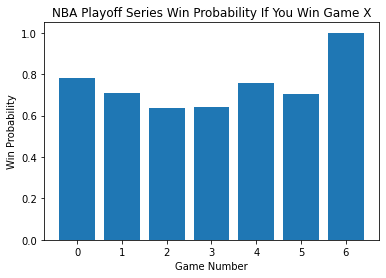

In [ ]:
import matplotlib.pyplot as plt
ys = [game_1_p, game_2_p, game_3_p, game_4_p, game_5_p, game_6_p, game_7_p]
xs = list(range(7))
plt.bar(xs, ys)
plt.title("NBA Playoff Series Win Probability If You Win Game X")
plt.xlabel("Game Number")
plt.ylabel("Win Probability")
plt.show()